# Calculate Price Based Features

In [1]:
import pandas as pd
import numpy as np
import os

def generate_price_features(input_csv_path, output_dir=None, price_col='close'):
    # Load and sort
    df = pd.read_csv(input_csv_path, parse_dates=['date'])
    df.sort_values('date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # === Log Daily Return ===
    df['daily_return'] = np.log(df[price_col] / df[price_col].shift(1))

    # === Annualized Returns ===
    def annualized_return(period_days):
        return ((df[price_col] / df[price_col].shift(period_days)) ** (252 / period_days)) - 1

    df['ann_return_1w'] = annualized_return(5)
    df['ann_return_2w'] = annualized_return(10)
    df['ann_return_1m'] = annualized_return(21)

    # === 7-Day Rolling & Annualized Volatility ===
    df['rolling_vol_7d'] = df['daily_return'].rolling(window=7).std()
    df['ann_volatility'] = df['rolling_vol_7d'] * np.sqrt(252)

    # === MACD: 1 Week vs 1 Month ===
    df['ema_1w'] = df[price_col].ewm(span=5, adjust=False).mean()
    df['ema_1m'] = df[price_col].ewm(span=21, adjust=False).mean()
    df['macd_1w_1m'] = df['ema_1w'] - df['ema_1m']

    # === Save to File ===
    base_name = os.path.basename(input_csv_path)
    ticker = base_name.split('_')[0]
    output_filename = f"{ticker}_with_features.csv"
    output_path = os.path.join(output_dir or os.path.dirname(input_csv_path), output_filename)

    df.to_csv(output_path, index=False)
    print(f"✅ Saved: {output_path}")

    return df


In [2]:
import os
data_dir = "Data"
for file in os.listdir(data_dir):
    if file.endswith('_daily_aggregated.csv'):
        file_path = os.path.join(data_dir, file)
        generate_price_features(file_path)


✅ Saved: Data/AAPL_with_features.csv
✅ Saved: Data/TMO_with_features.csv
✅ Saved: Data/JNJ_with_features.csv
✅ Saved: Data/BA_with_features.csv
✅ Saved: Data/TSLA_with_features.csv
✅ Saved: Data/COST_with_features.csv
✅ Saved: Data/VLO_with_features.csv
✅ Saved: Data/NVDA_with_features.csv
✅ Saved: Data/AMZN_with_features.csv


# Calculate Sentiment Features and Merge with Price Features

In [3]:
def generate_and_merge_features(directory='.', sentiment_suffix='_daily_sentiment_summary.csv', price_suffix='_with_features.csv'):
    all_data = []
    merged_data = {}

    # Process and Save Sentiment Features
    for filename in os.listdir(directory):
        if filename.endswith(sentiment_suffix):
            ticker = filename.split('_')[0]
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)

            df.rename(columns={"adjusted_date": "date"}, inplace=True)
            df['date'] = pd.to_datetime(df['date']).dt.date
            df['ticker'] = ticker
            all_data.append(df)

    if not all_data:
        print("⚠️ No sentiment files found.")
        return {}

    combined_df = pd.concat(all_data, ignore_index=True)
    total_news_by_day = combined_df.groupby('date')['news_count'].sum().reset_index(name='total_news_count')
    combined_df = combined_df.merge(total_news_by_day, on='date')
    combined_df['news_frequency'] = combined_df['news_count'] / combined_df['total_news_count']
    combined_df['product'] = combined_df['mean_sentiment'] * combined_df['news_frequency']

    # Save sentiment features per ticker
    for ticker in combined_df['ticker'].unique():
        df_ticker = combined_df[combined_df['ticker'] == ticker][
            ['date', 'mean_sentiment', 'sentiment_variance', 'news_count', 'news_frequency', 'product']
        ].copy()
        df_ticker.to_csv(os.path.join(directory, f'{ticker}_sentiment_with_features.csv'), index=False)
        print(f"✅ Saved sentiment features: {ticker}_sentiment_with_features.csv")

    # Merge with Price Features 
    for ticker in combined_df['ticker'].unique():
        sentiment_file = os.path.join(directory, f'{ticker}_sentiment_with_features.csv')
        price_file = os.path.join(directory, f'{ticker}{price_suffix}')

        if os.path.exists(price_file):
            df_sentiment = pd.read_csv(sentiment_file, parse_dates=['date'])
            df_price = pd.read_csv(price_file, parse_dates=['date'])

           
            df_merged = pd.merge(df_price, df_sentiment, on='date', how='inner')
            merged_data[ticker] = df_merged
            print(f"🔗 Merged data for {ticker} ({len(df_merged)} rows)")

            
            df_merged.to_csv(os.path.join(directory, f'{ticker}_with_sentiment_features_with_product.csv'), index=False)
            print(f"📁 Saved merged features: {ticker}_with_sentiment_features_with_product.csv")
        else:
            print(f"⚠️ Price feature file not found for {ticker}: {price_file}")

    return merged_data

In [4]:
merged_results = generate_and_merge_features(directory='Data')

✅ Saved sentiment features: JNJ_sentiment_with_features.csv
✅ Saved sentiment features: AMZN_sentiment_with_features.csv
✅ Saved sentiment features: NVDA_sentiment_with_features.csv
✅ Saved sentiment features: COST_sentiment_with_features.csv
✅ Saved sentiment features: BA_sentiment_with_features.csv
✅ Saved sentiment features: TMO_sentiment_with_features.csv
✅ Saved sentiment features: TSLA_sentiment_with_features.csv
✅ Saved sentiment features: VLO_sentiment_with_features.csv
✅ Saved sentiment features: AAPL_sentiment_with_features.csv
🔗 Merged data for JNJ (1092 rows)
📁 Saved merged features: JNJ_with_sentiment_features_with_product.csv
🔗 Merged data for AMZN (1107 rows)
📁 Saved merged features: AMZN_with_sentiment_features_with_product.csv
🔗 Merged data for NVDA (1104 rows)
📁 Saved merged features: NVDA_with_sentiment_features_with_product.csv
🔗 Merged data for COST (808 rows)
📁 Saved merged features: COST_with_sentiment_features_with_product.csv
🔗 Merged data for BA (884 rows)
📁 S

# Correlation Matrix of All Features

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_correlations(directory='.', suffix='_with_sentiment_features_with_product.csv', output_dir='correlation_plots'):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(directory):
        if filename.endswith(suffix):
            ticker = filename.split('_')[0]
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)

            # Drop non-numeric or unwanted columns
            df_numeric = df.select_dtypes(include='number')  # Automatically removes 'date', etc.

            # Compute correlation matrix
            corr_matrix = df_numeric.corr()

            # Plot heatmap
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
            plt.title(f'{ticker} Feature Correlation Heatmap', fontsize=14)
            plt.tight_layout()

            # Save the figure
            plot_path = os.path.join(output_dir, f'{ticker}_correlation_heatmap.png')
            plt.savefig(plot_path)
            plt.show()

            print(f"✅ Saved heatmap for {ticker}: {plot_path}")


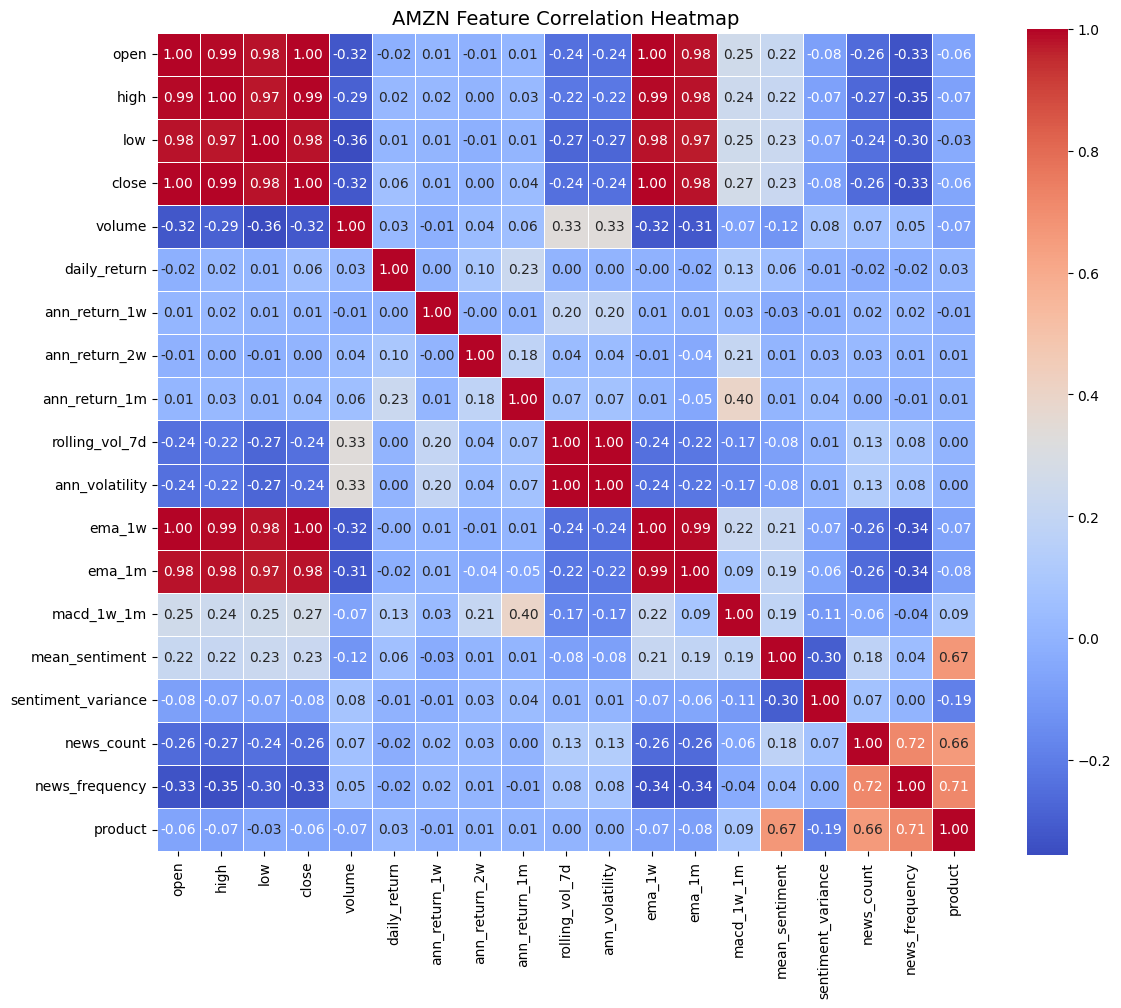

✅ Saved heatmap for AMZN: correlation_plots/AMZN_correlation_heatmap.png


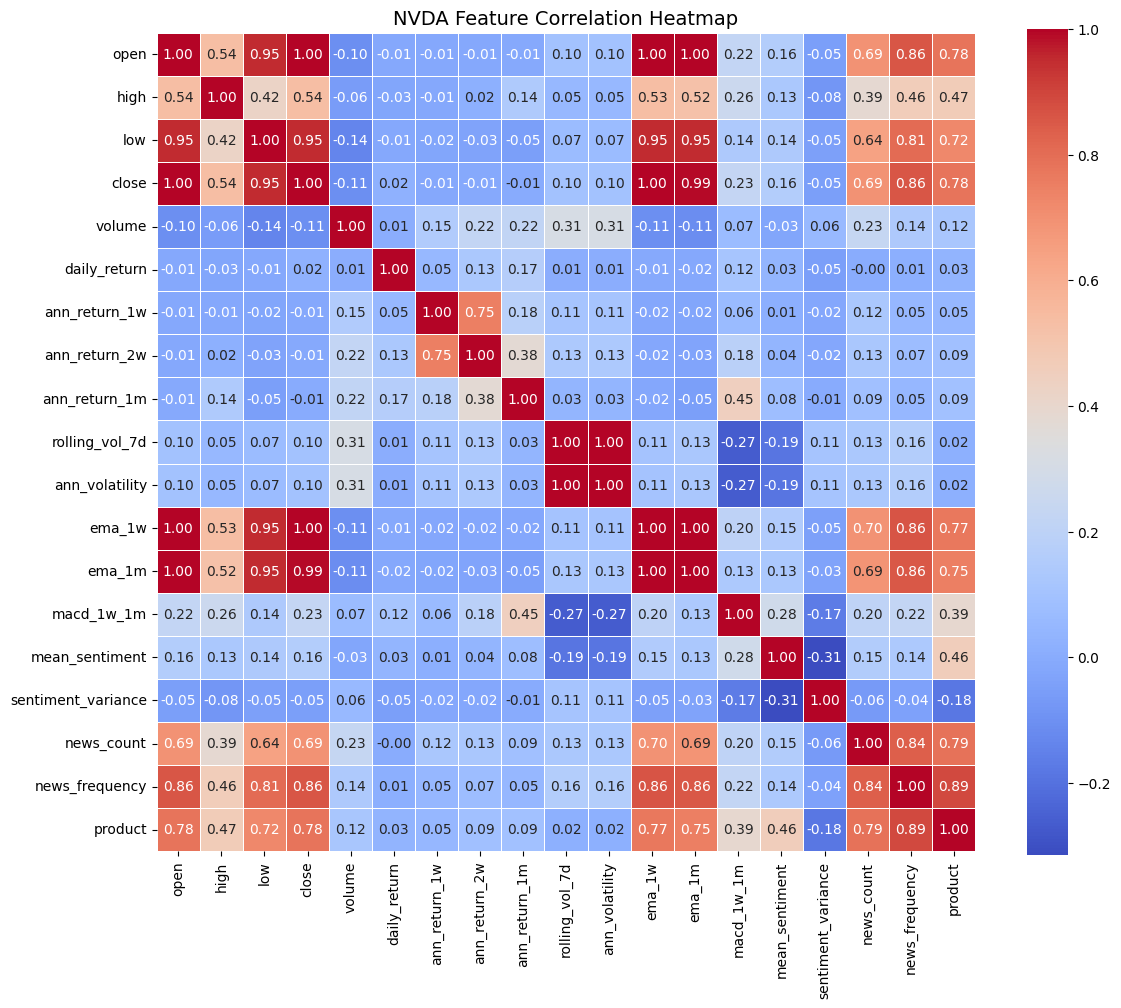

✅ Saved heatmap for NVDA: correlation_plots/NVDA_correlation_heatmap.png


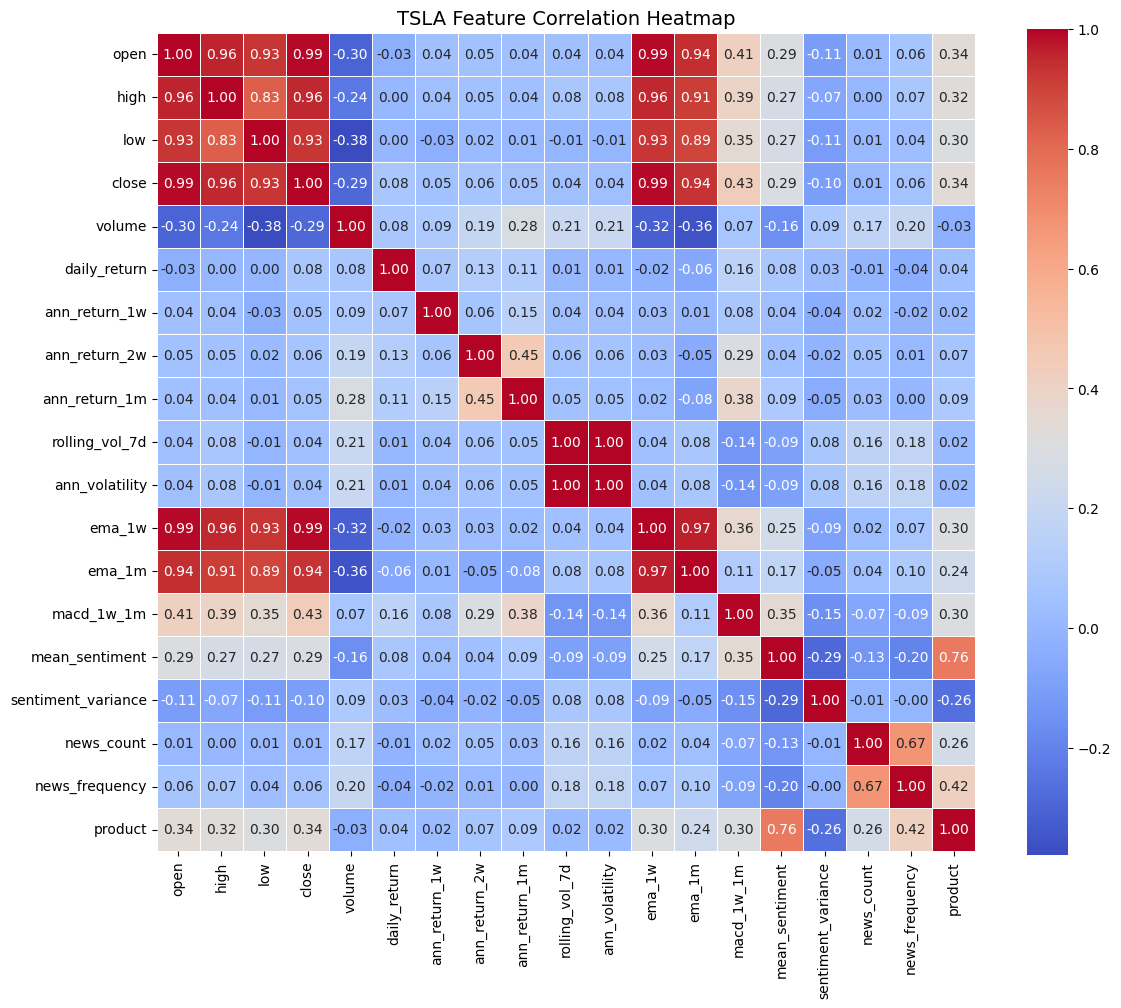

✅ Saved heatmap for TSLA: correlation_plots/TSLA_correlation_heatmap.png


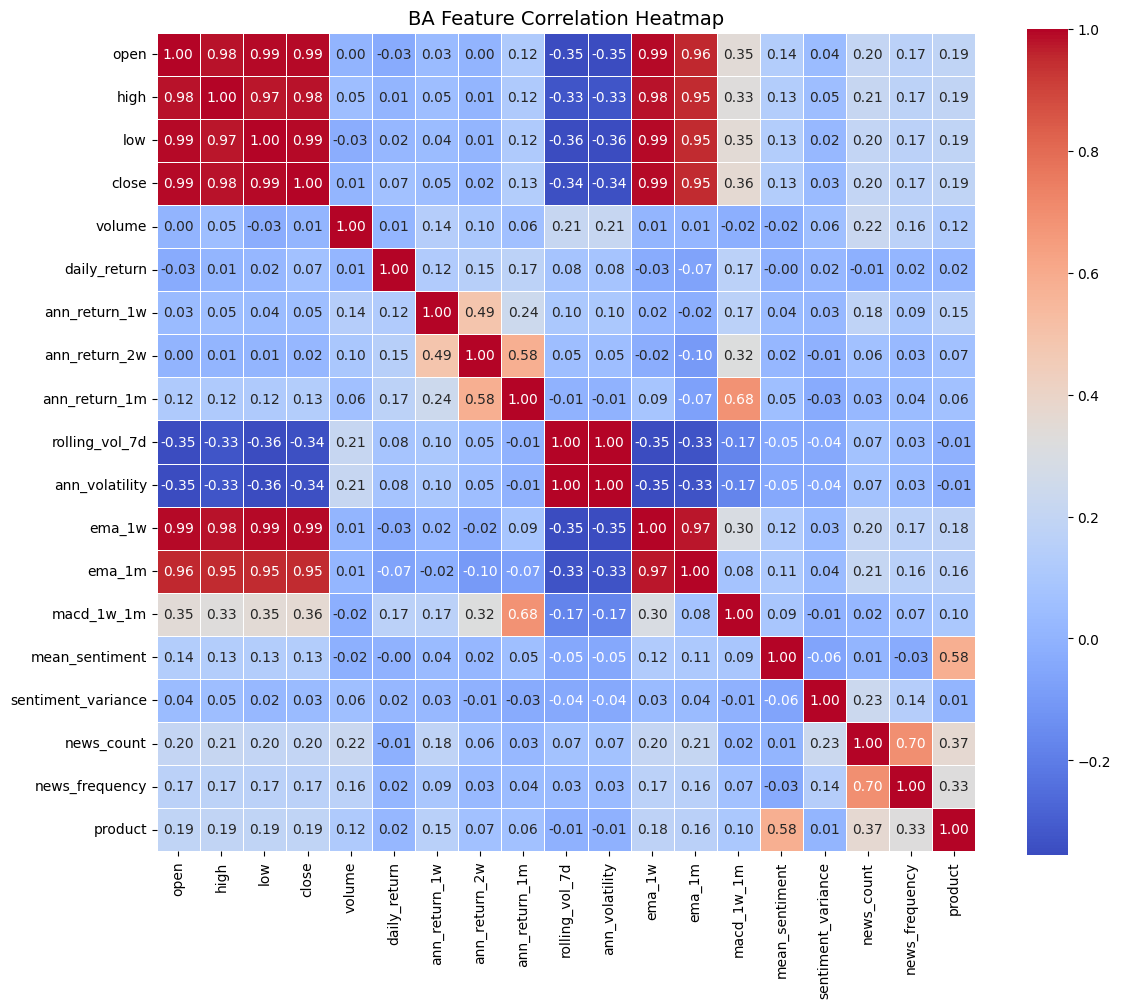

✅ Saved heatmap for BA: correlation_plots/BA_correlation_heatmap.png


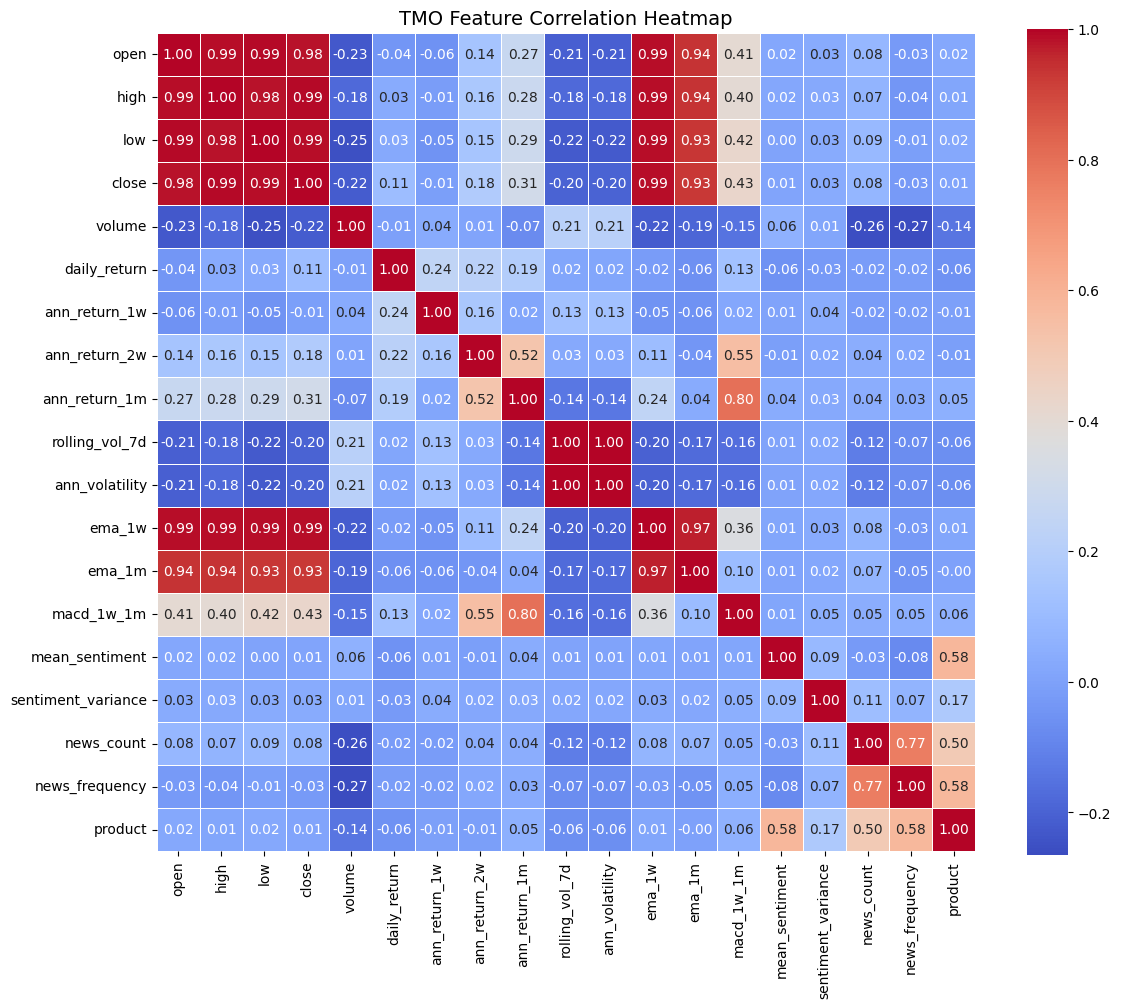

✅ Saved heatmap for TMO: correlation_plots/TMO_correlation_heatmap.png


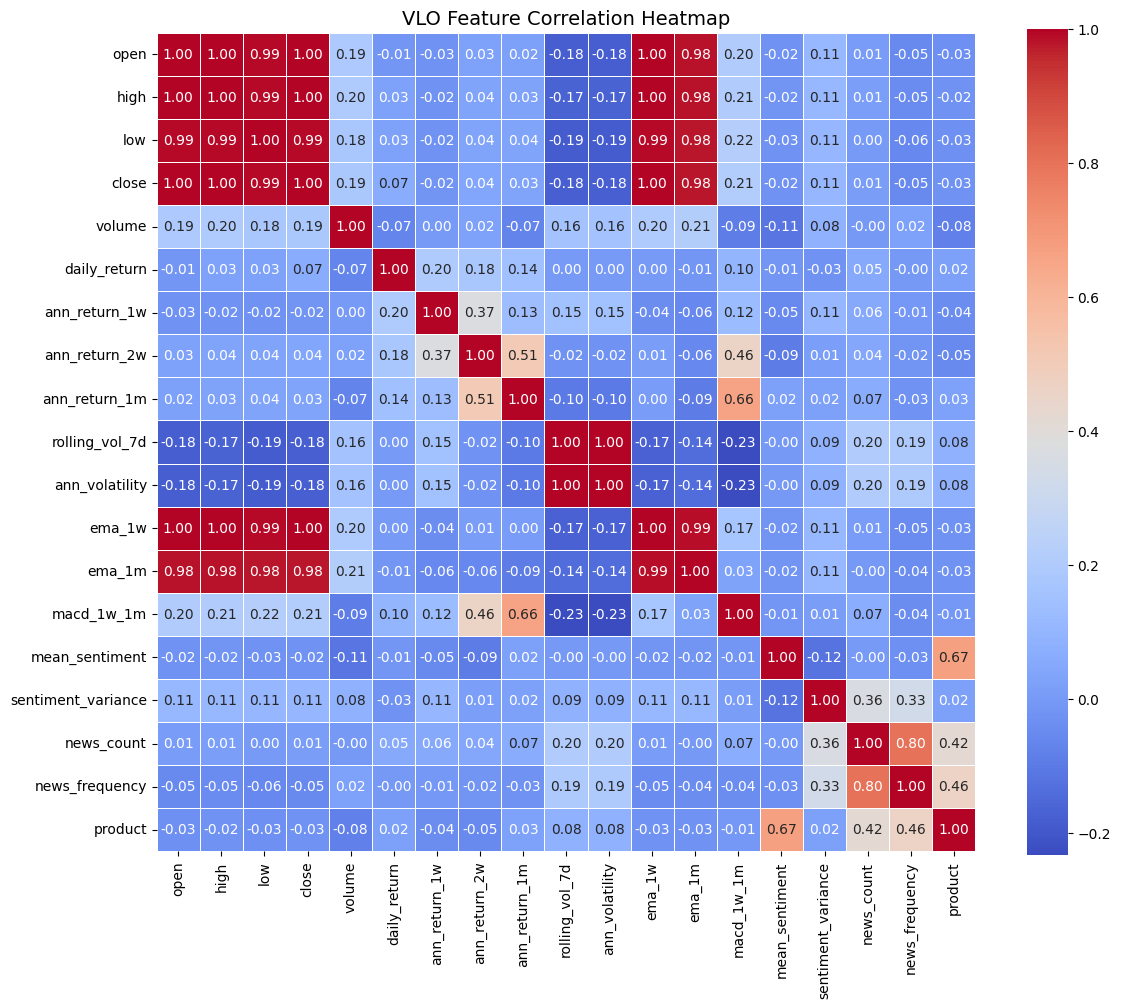

✅ Saved heatmap for VLO: correlation_plots/VLO_correlation_heatmap.png


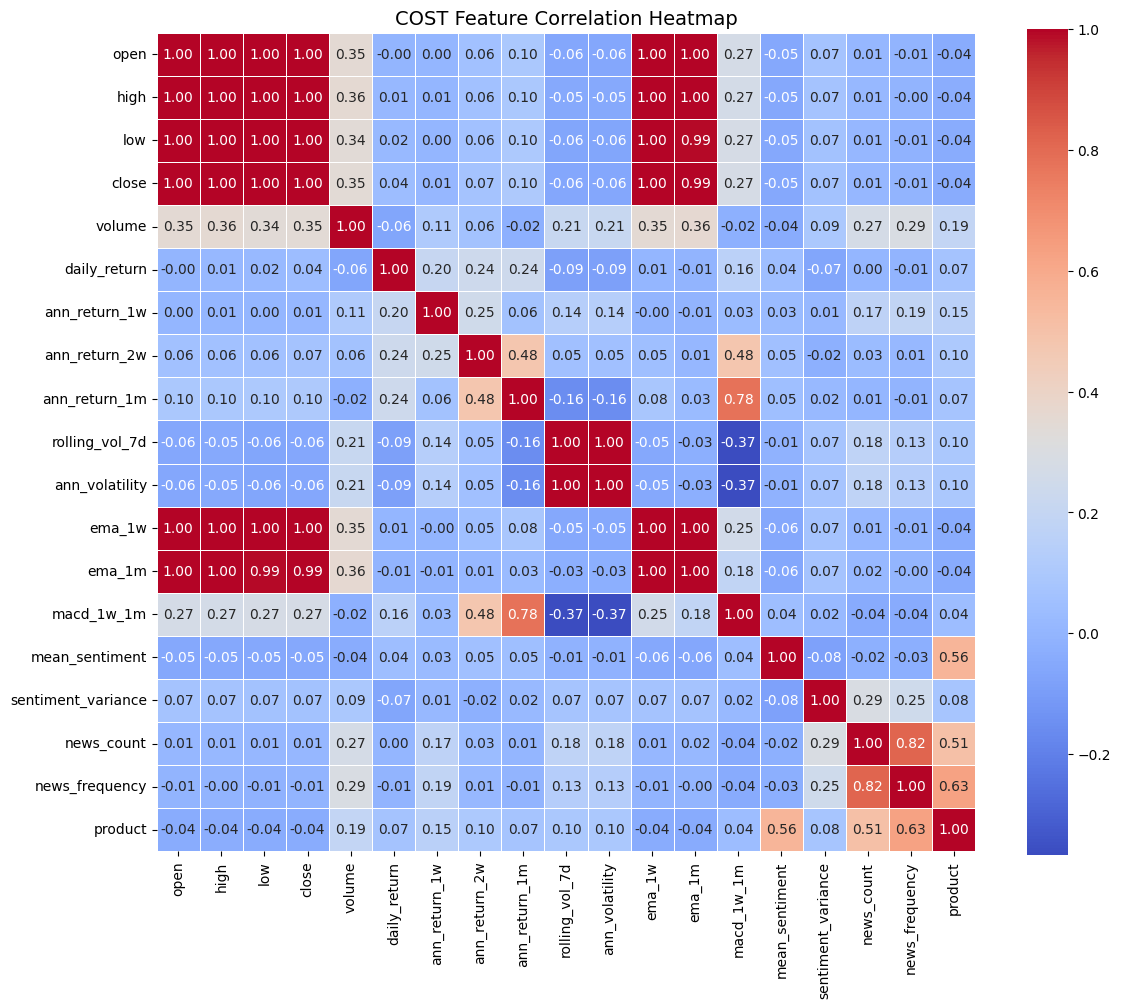

✅ Saved heatmap for COST: correlation_plots/COST_correlation_heatmap.png


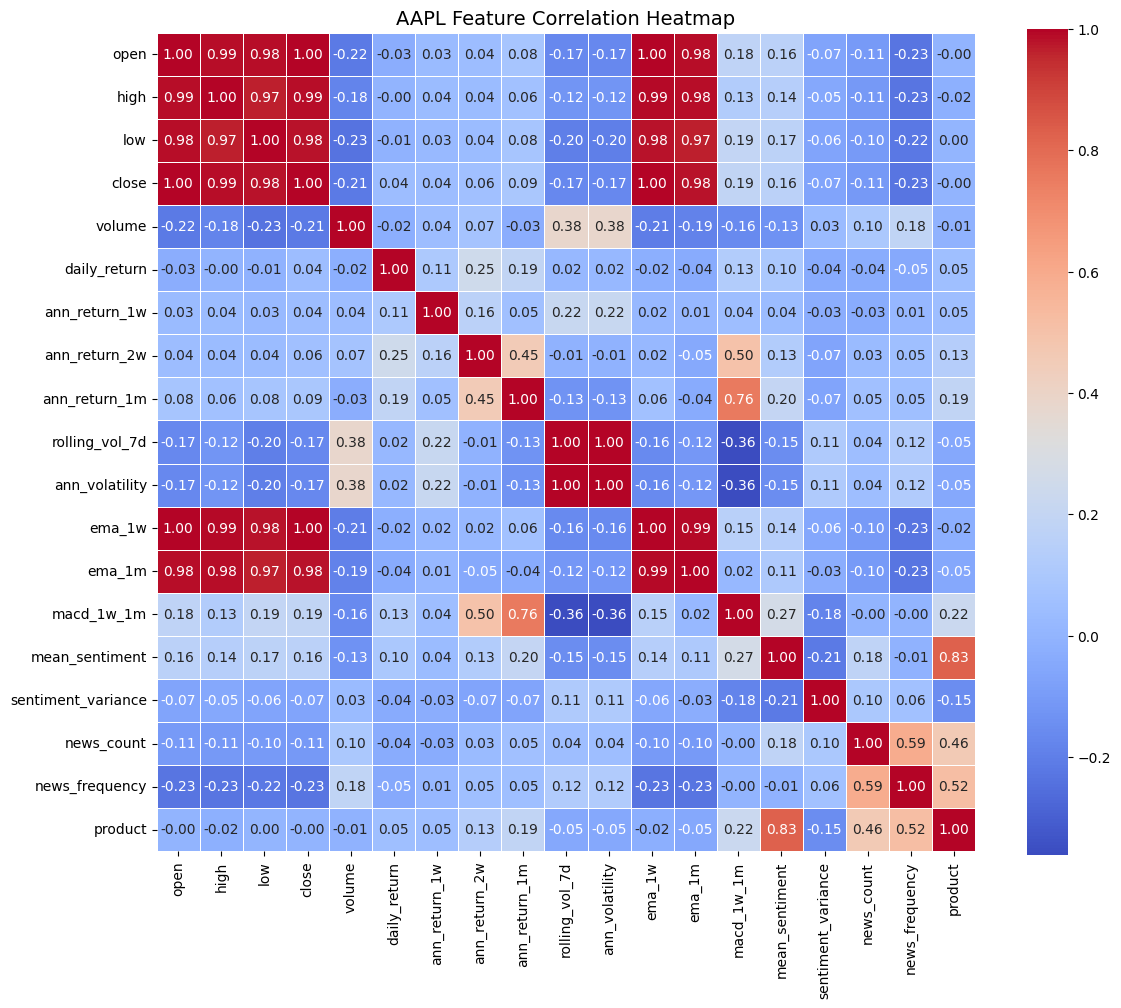

✅ Saved heatmap for AAPL: correlation_plots/AAPL_correlation_heatmap.png


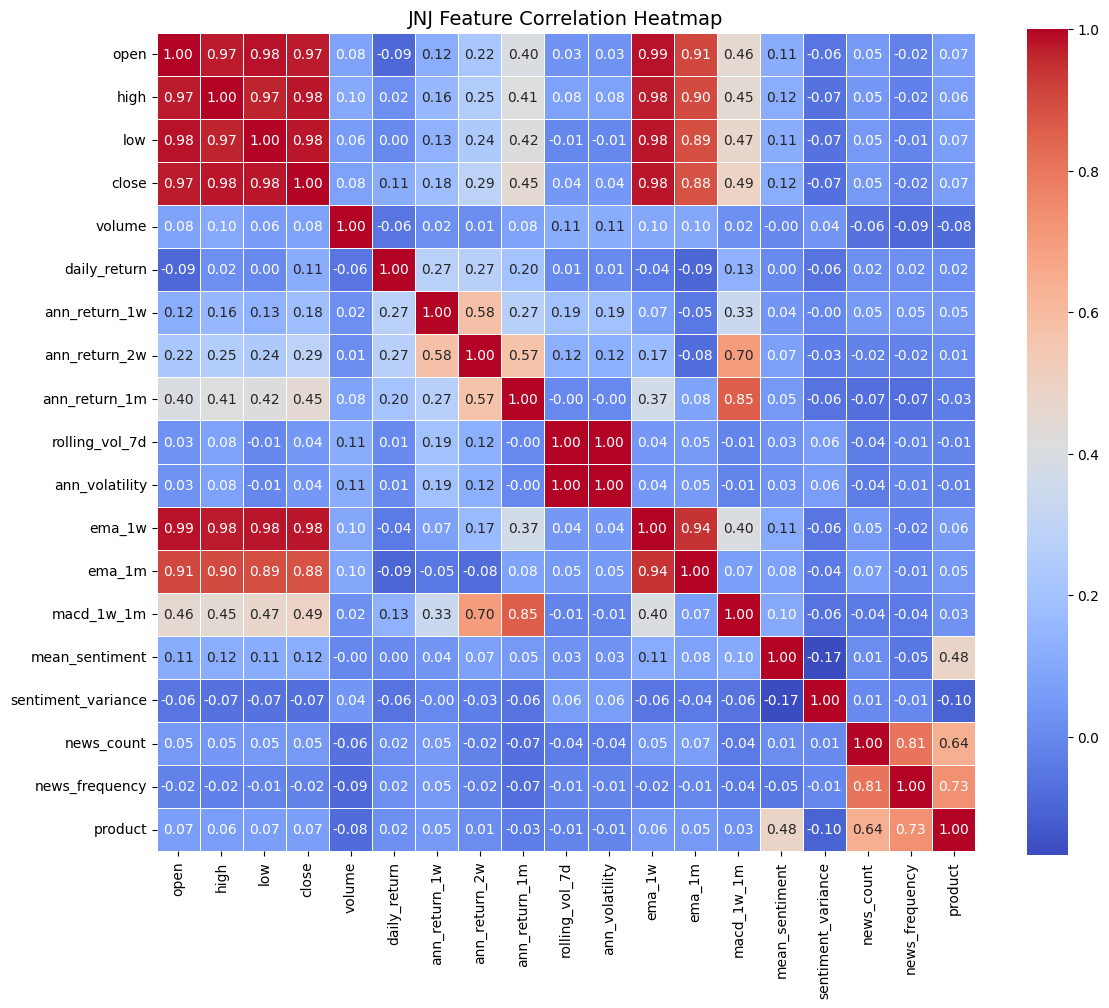

✅ Saved heatmap for JNJ: correlation_plots/JNJ_correlation_heatmap.png


In [6]:
plot_feature_correlations(directory='Data')